## initial code for our Hand Gesture Recognition

In [1]:
# ML models imports
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# destribution models imports
from scipy.stats import randint, uniform

# Data manipulation imports
import numpy as np
import pandas as pd
import tqdm as tqdm

# visualisation models imports
import matplotlib.pyplot as plt

# image processing imports
import skimage.io as io
import cv2
from skimage.transform import resize

# dealing with files
import os

# visual dataset (to test randomized gridsearch not needed for now)
from sklearn.datasets import make_hastie_10_2  # to test our models

# from utils import prepareData, LoadData, FeatureExtraction, preprocess
import csv

In [2]:
def segment(image):
    blured_image = cv2.GaussianBlur(image, (7, 7), 0)
    ycbcr_image = cv2.cvtColor(blured_image, cv2.COLOR_BGR2YCrCb)
    # Extract the Cr channel
    cr_channel = ycbcr_image[:,:,1]

    # Apply thresholding to obtain a binary image
    _, binary_img = cv2.threshold(cr_channel,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Define the structuring element for the closing operation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (80, 80))

    # Define the structuring element for the eroding small noise
    smallKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    #Apply erosion to remove small noise
    eroded_img=cv2.morphologyEx(binary_img,cv2.MORPH_ERODE,smallKernel)
    # Perform the closing operation
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

    # Find the contours in the binary image
    contours, hierarchy = cv2.findContours(eroded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filling the contours on a copy of the original image
    # img_contours = cv2.cvtColor(cr_channel, cv2.COLOR_GRAY2BGR)
    # cv2.drawContours(img_contours, contours, -1, (0, 0, 0), -1)

    segmented_image = closed_img.copy()
    cv2.drawContours(segmented_image, contours, -1, 255, -1)

    return segmented_image

def chooseGamma(image):
    grayScale= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayScale=np.array(grayScale)
    meanVal=np.mean(grayScale)
    if meanVal < 110:
        gamma=2.5
    elif meanVal <115:
        gamma=2.3
    elif meanVal <120: 
        gamma=2.1
    elif meanVal <125:
        gamma=1.8
    elif meanVal <130: 
        gamma=1.7
    elif meanVal <135:
        gamma=1.5
    elif meanVal <140:
        gamma=0.9
    elif meanVal <145:
        gamma=0.8
    elif meanVal <150: 
        gamma=0.75
    else:
        gamma=0.8
         
    return adjust_gamma(image,gamma)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)




In [3]:
def segment(image):
    blured_image = cv2.GaussianBlur(image, (7, 7), 0)
    ycbcr_image = cv2.cvtColor(blured_image, cv2.COLOR_BGR2YCrCb)
    # Extract the Cr channel
    cr_channel = ycbcr_image[:,:,1]

    # Apply thresholding to obtain a binary image
    _, binary_img = cv2.threshold(cr_channel,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Define the structuring element for the closing operation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))

    # Perform the closing operation
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

    # Find the contours in the binary image
    contours, hierarchy = cv2.findContours(closed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filling the contours on a copy of the original image
    # img_contours = cv2.cvtColor(cr_channel, cv2.COLOR_GRAY2BGR)
    # cv2.drawContours(img_contours, contours, -1, (0, 0, 0), -1)

    segmented_image = closed_img.copy()
    cv2.drawContours(segmented_image, contours, -1, 255, -1)

    return segmented_image

In [3]:
def featureScalingUsingSklearn(features):
    '''
        Inputs:
            features: the features to be scaled
        Outputs:
            scaledFeatures: the scaled features
        Note: 
            this function is used to scale the features to be in the range [0,1]
            this is done by subtracting the minimum value from each feature and then dividing by the range
            of the feature.
        Reference: 
            https://stackabuse.com/feature-scaling-data-with-scikit-learn-for-machine-learning-in-python/
    '''
    scaler = StandardScaler()
    scaledFeatures = scaler.fit_transform(features)
    return scaledFeatures

In [4]:
def Blobs(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Laplacian of Gaussian (LoG) filter
    log = cv2.GaussianBlur(gray, (5, 5), 0)
    log = cv2.Laplacian(log, cv2.CV_8U, ksize=5)

    # Threshold the filtered image to obtain a binary image
    _, binary = cv2.threshold(log, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Apply morphological operations to remove noise and fill gaps in the blobs
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Detect and extract the blobs using the SimpleBlobDetector in OpenCV
    params = cv2.SimpleBlobDetector_Params()
    params.minThreshold = 0
    params.maxThreshold = 255
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(binary)

    extracted_blobs = []

    for kp in keypoints:
        f = extract_from_keypoint(kp)
        extracted_blobs.append(f)

    return np.asarray(extracted_blobs[:200]).flatten()
    


In [45]:
len(np.asarray(blobs).flatten())

1276

In [5]:
def extract_from_keypoint(kp):
    # Extract relevant attributes from keypoint
    x, y = kp.pt
    size = kp.size
    angle = kp.angle
    # Compute and normalize the angle in the range [0, 1)
    angle = angle / 360.0
    if angle < 0:
        angle += 1.0

    # Create a feature array
    features = np.array([x, y, size, angle], dtype=np.float32)

    return features


In [3]:
def NU3U(originalImage):
    image=chooseGamma(originalImage)
    mask =segment(image)
    # image=cv2.bitwise_and(originalImage,originalImage,mask=mask)
    # image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return mask

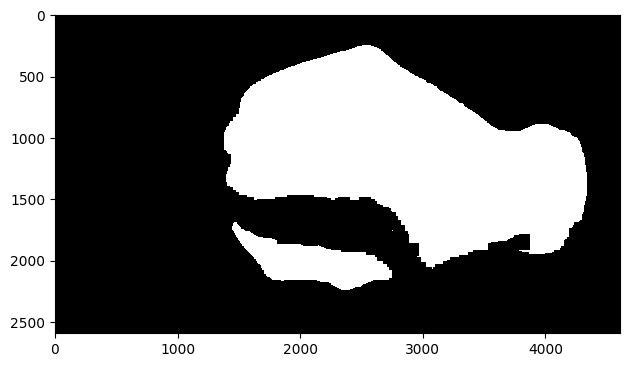

In [13]:
m = segment(image)
io.imshow(m)

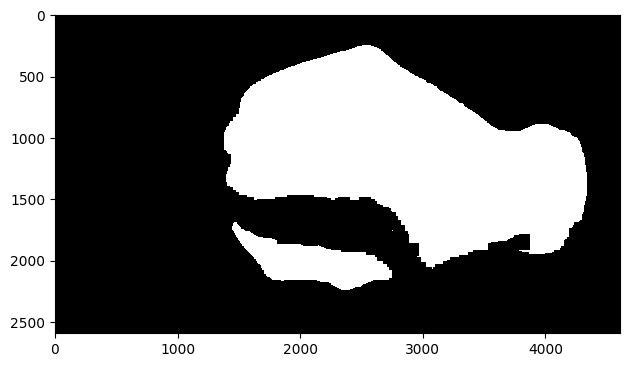

In [12]:
image = io.imread('0_men (7).JPG')
m = NU3U(image)
io.imshow(m)

In [4]:
def FeatureExtraction(image):
        
    # Extract the hog features
    # block_norm uses L2 norm with hysterisis for reducing effect of illuminacity
    # transform_sqrt for applying gamma correction
    # preprocessed_image = segment(image)
    preprocessed_image = NU3U(image)
    
    # resized_image = resize(preprocessed_image,(64,128))   # downscaing from approx 2500x4000 to 500x500
    resized_image = resize(preprocessed_image,(64,128))

    hog_features = hog(resized_image, block_norm='L2-Hys', feature_vector=True, transform_sqrt=True, pixels_per_cell=(12, 12), cells_per_block=(2, 2))

    

    return hog_features

In [5]:
def LoadData():
    Features=[]
    labels=[]

    i = 0
    for gender in ["men","Women"]:
        datadir = r"Sample\{}".format(gender)
        # loop over gender
        for hand in os.listdir(datadir): 
            # loop over each class [0,1,2,3,4,5]
            for img in os.listdir(datadir+ "/" +str(hand)):
                # ignoring anything except images
                if((img.split('.')[-1]).lower() not in ['jpg','png','jpeg']):
                    continue

                # loading our images
                img_array=io.imread(datadir + "/" + str(hand) + "/" + img )  # approx 2500 * 4000

                # append extracted features to Featurees list   
                Feature = FeatureExtraction(img_array)        
                Features.append(Feature) 

                # append class of image.
                labels.append(hand)  

                print(f'image Number: {i}')
                i+=1

    return np.asarray(Features),np.asarray(labels)

In [6]:
Features, labels = LoadData() 

image Number: 0
image Number: 1
image Number: 2
image Number: 3
image Number: 4
image Number: 5
image Number: 6
image Number: 7
image Number: 8
image Number: 9
image Number: 10
image Number: 11
image Number: 12
image Number: 13
image Number: 14
image Number: 15
image Number: 16
image Number: 17
image Number: 18
image Number: 19
image Number: 20
image Number: 21
image Number: 22
image Number: 23
image Number: 24
image Number: 25
image Number: 26
image Number: 27
image Number: 28
image Number: 29
image Number: 30
image Number: 31
image Number: 32
image Number: 33
image Number: 34
image Number: 35
image Number: 36
image Number: 37
image Number: 38
image Number: 39
image Number: 40
image Number: 41
image Number: 42
image Number: 43
image Number: 44
image Number: 45
image Number: 46
image Number: 47
image Number: 48
image Number: 49
image Number: 50
image Number: 51
image Number: 52
image Number: 53
image Number: 54
image Number: 55
image Number: 56
image Number: 57
image Number: 58


In [195]:
# labels

In [64]:
np.save('labels_nu3u.npy', labels)
np.save('features_nu3u.npy', Features)
# labels=np.load('labels_nu3.npy')
# Features=np.load('features_nu3.npy')  
# len(labels)
Features[0].max()

0.5693317386726928

0.0

In [197]:
# Use Pandas to read the CSV file in chunks of 1000 rows
# chunk_size = 10
# for chunk in pd.read_csv('Features.csv', chunksize=chunk_size):
#     # Process each chunk of data here
#     print(chunk.head())

In [198]:
# test = np.load('Features/1.npy')
# test.max()

In [199]:
# img = cv2.imread('1_men (2).JPG')
# lower_rgb=np.array([0, 0, 0],dtype="uint8")
# upper_rgb=np.array([230, 230, 230],dtype="uint8")
# skin_region=cv2.inRange(img,lower_rgb,upper_rgb)
# cv2.imwrite("segmented_2.jpg",skin_region)

* # Selecting the best model

- ### Define hyperparameter grids for each model

In [7]:
param_distributions = {
    'RandomForestClassifier': {
        'n_estimators': randint(50, 500),
        'max_depth': randint(2, 20),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2']
    },
    'GradientBoostingClassifier': {
        'learning_rate': uniform(0.01, 0.2),
        'n_estimators': randint(50, 500),
        'max_depth': randint(2, 20),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2']
    },
    'SVC': {
        'C': uniform(0.01, 100),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4, 5,6],
        'gamma': ['scale', 'auto'] + list(np.arange(0.1, 1, 0.1)),
        'coef0': [-1, 0, 1],
        'shrinking': [True, False],
        'probability': [True, False],
        'tol': [1e-5, 1e-4, 1e-3],
        'max_iter': [100, 500, 1000, -1]
    },
    'LogisticRegression': {
        'C': uniform(0.01, 10),
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': randint(50, 500)
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': randint(2, 20),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2']
    },
    'KNeighborsClassifier': {
        'n_neighbors': randint(3, 30),
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'leaf_size': randint(10, 100)
    },
    'GaussianNB': {
        'var_smoothing': uniform(1e-09, 1e-07)
    },
    'MLPClassifier': {
        'hidden_layer_sizes': [(50, 50), (100,), (100, 50)],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': uniform(0.0001, 0.01),
        'max_iter': randint(100, 1000)
    }
}

- ### Create a list of models to train (as example)

In [8]:
models = [
    SVC(),
    GaussianNB(),
    KNeighborsClassifier(),
    RandomForestClassifier()
]

- ### Loop over the models and fit  

In [9]:
# load our dummy data to test the randomizedSearche function
x,y = Features,labels
df = pd.DataFrame(x)
df['Y'] = y

train, test = train_test_split(df, test_size=0.2) # this function shuffles the data points, and splits the data into
                                                  # 80% training set and 20% test set (indicated by test_size=0.2)
X_train, Y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, Y_test = test.iloc[:, :-1], test.iloc[:, -1]

In [10]:
for i, model in enumerate(models):
    print(f'Training Model {i+1}/{len(models)}: {str(model)[:-2]}')
    # Define randomized grid search
    random_search = RandomizedSearchCV(model, param_distributions[str(model)[:-2]], n_iter=10,cv=5, n_jobs=-1) # n_jobs means number of jobs to run in parallel. None means 1,
                                                                                                                # -1 means using all processors 😈.
    # Fit the randomized grid search to the data
    random_search.fit(X_train, Y_train)
    print(f'Best score: {random_search.best_score_:.3f}')
    print(f'Best parameters: {random_search.best_params_}\n')

Training Model 1/4: SVC
Best score: 0.644
Best parameters: {'C': 10.754603981586087, 'coef0': 0, 'degree': 5, 'gamma': 0.5, 'kernel': 'linear', 'max_iter': 100, 'probability': False, 'shrinking': True, 'tol': 1e-05}

Training Model 2/4: GaussianNB
Best score: 0.467
Best parameters: {'var_smoothing': 4.097047531916136e-08}

Training Model 3/4: KNeighborsClassifier
Best score: 0.684
Best parameters: {'algorithm': 'brute', 'leaf_size': 31, 'n_neighbors': 3, 'weights': 'distance'}

Training Model 4/4: RandomForestClassifier
Best score: 0.598
Best parameters: {'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 66}

